## The Variance of Absorption Spectra

From discussing the mechanics of absorption spectra, it was clear that absorption lines themselves do not have a constant magnitude for all temperatures and pressures. This section uses an approximate global atmosphere model to reproduce the atmosphere environment at different altitudes.

The nature of climate models is that they have many interlinked parameters. These relationships must be modelled when the goal is to produce the most accurate model possible. However, this project's scope is to build a reasonable approximation for pedagogy.

In [10]:
import sqlite3

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dur_utils import colours
from scipy import constants
from scipy.integrate import simpson
import simpletrans.isa
from simpletrans.optical_depth_functions import optical_depth

mpl.style.use("../CDS.mplstyle")

##  Standard Atmosphere Model
The "US Standard Atmosphere, 1976"{cite}`USAtmosphere` provides pressure, temperature, and density vertical profiles. The model takes values which are roughly representative of year-round mid-latitude conditions. The density profile is calculated using the temperature and pressure profiles through the ideal gas equation
```{math}
pV = n K_b T.
```
Where, $p$ is pressure, $V$ volume and $T$ temperature, n gives the number density of the gas and $K_b$ is Boltzmann's constant. The profiles given by the standard atmosphere model are plotted below.

As described in the section on [line broadening](./atmospheric_primer.md) line shapes vary with atmospheric conditions. An empirical atmospheric profile is used to calculate molecule concentrations and cross-section broadening. This enables the assessment of the effects of broadening.

In addition to the atmospheres' pressure and temperature changing the concentration of GHGs can change. A reasonable assumption in the troposphere, below $10 km$, is that the relative fractional abundances stay the same. Thus, the decrease in atmospheric density provides the main trail off for total absorption. However, the constant relative fraction of greenhouse gases assumption breaks down, particularly for water and ozone fractional abundances above the 10km mark. This is because water forms clouds and precipitates down, becoming much less abundant, and ozone is produced more rapidly at higher altitudes and its concentration peaks in the stratosphere.

Despite falling density and pressure, there is an increase in temperature after $20 km$. This temperature increase is due primarily to Ozone absorbing Shortwave UV-radiation, which is incoming from the sun. Such a temperature increase is not accounted for in our model as we look at longwave radiation exiting the atmosphere. Further encouraging us to limit the scope of the model to below $10 km$.



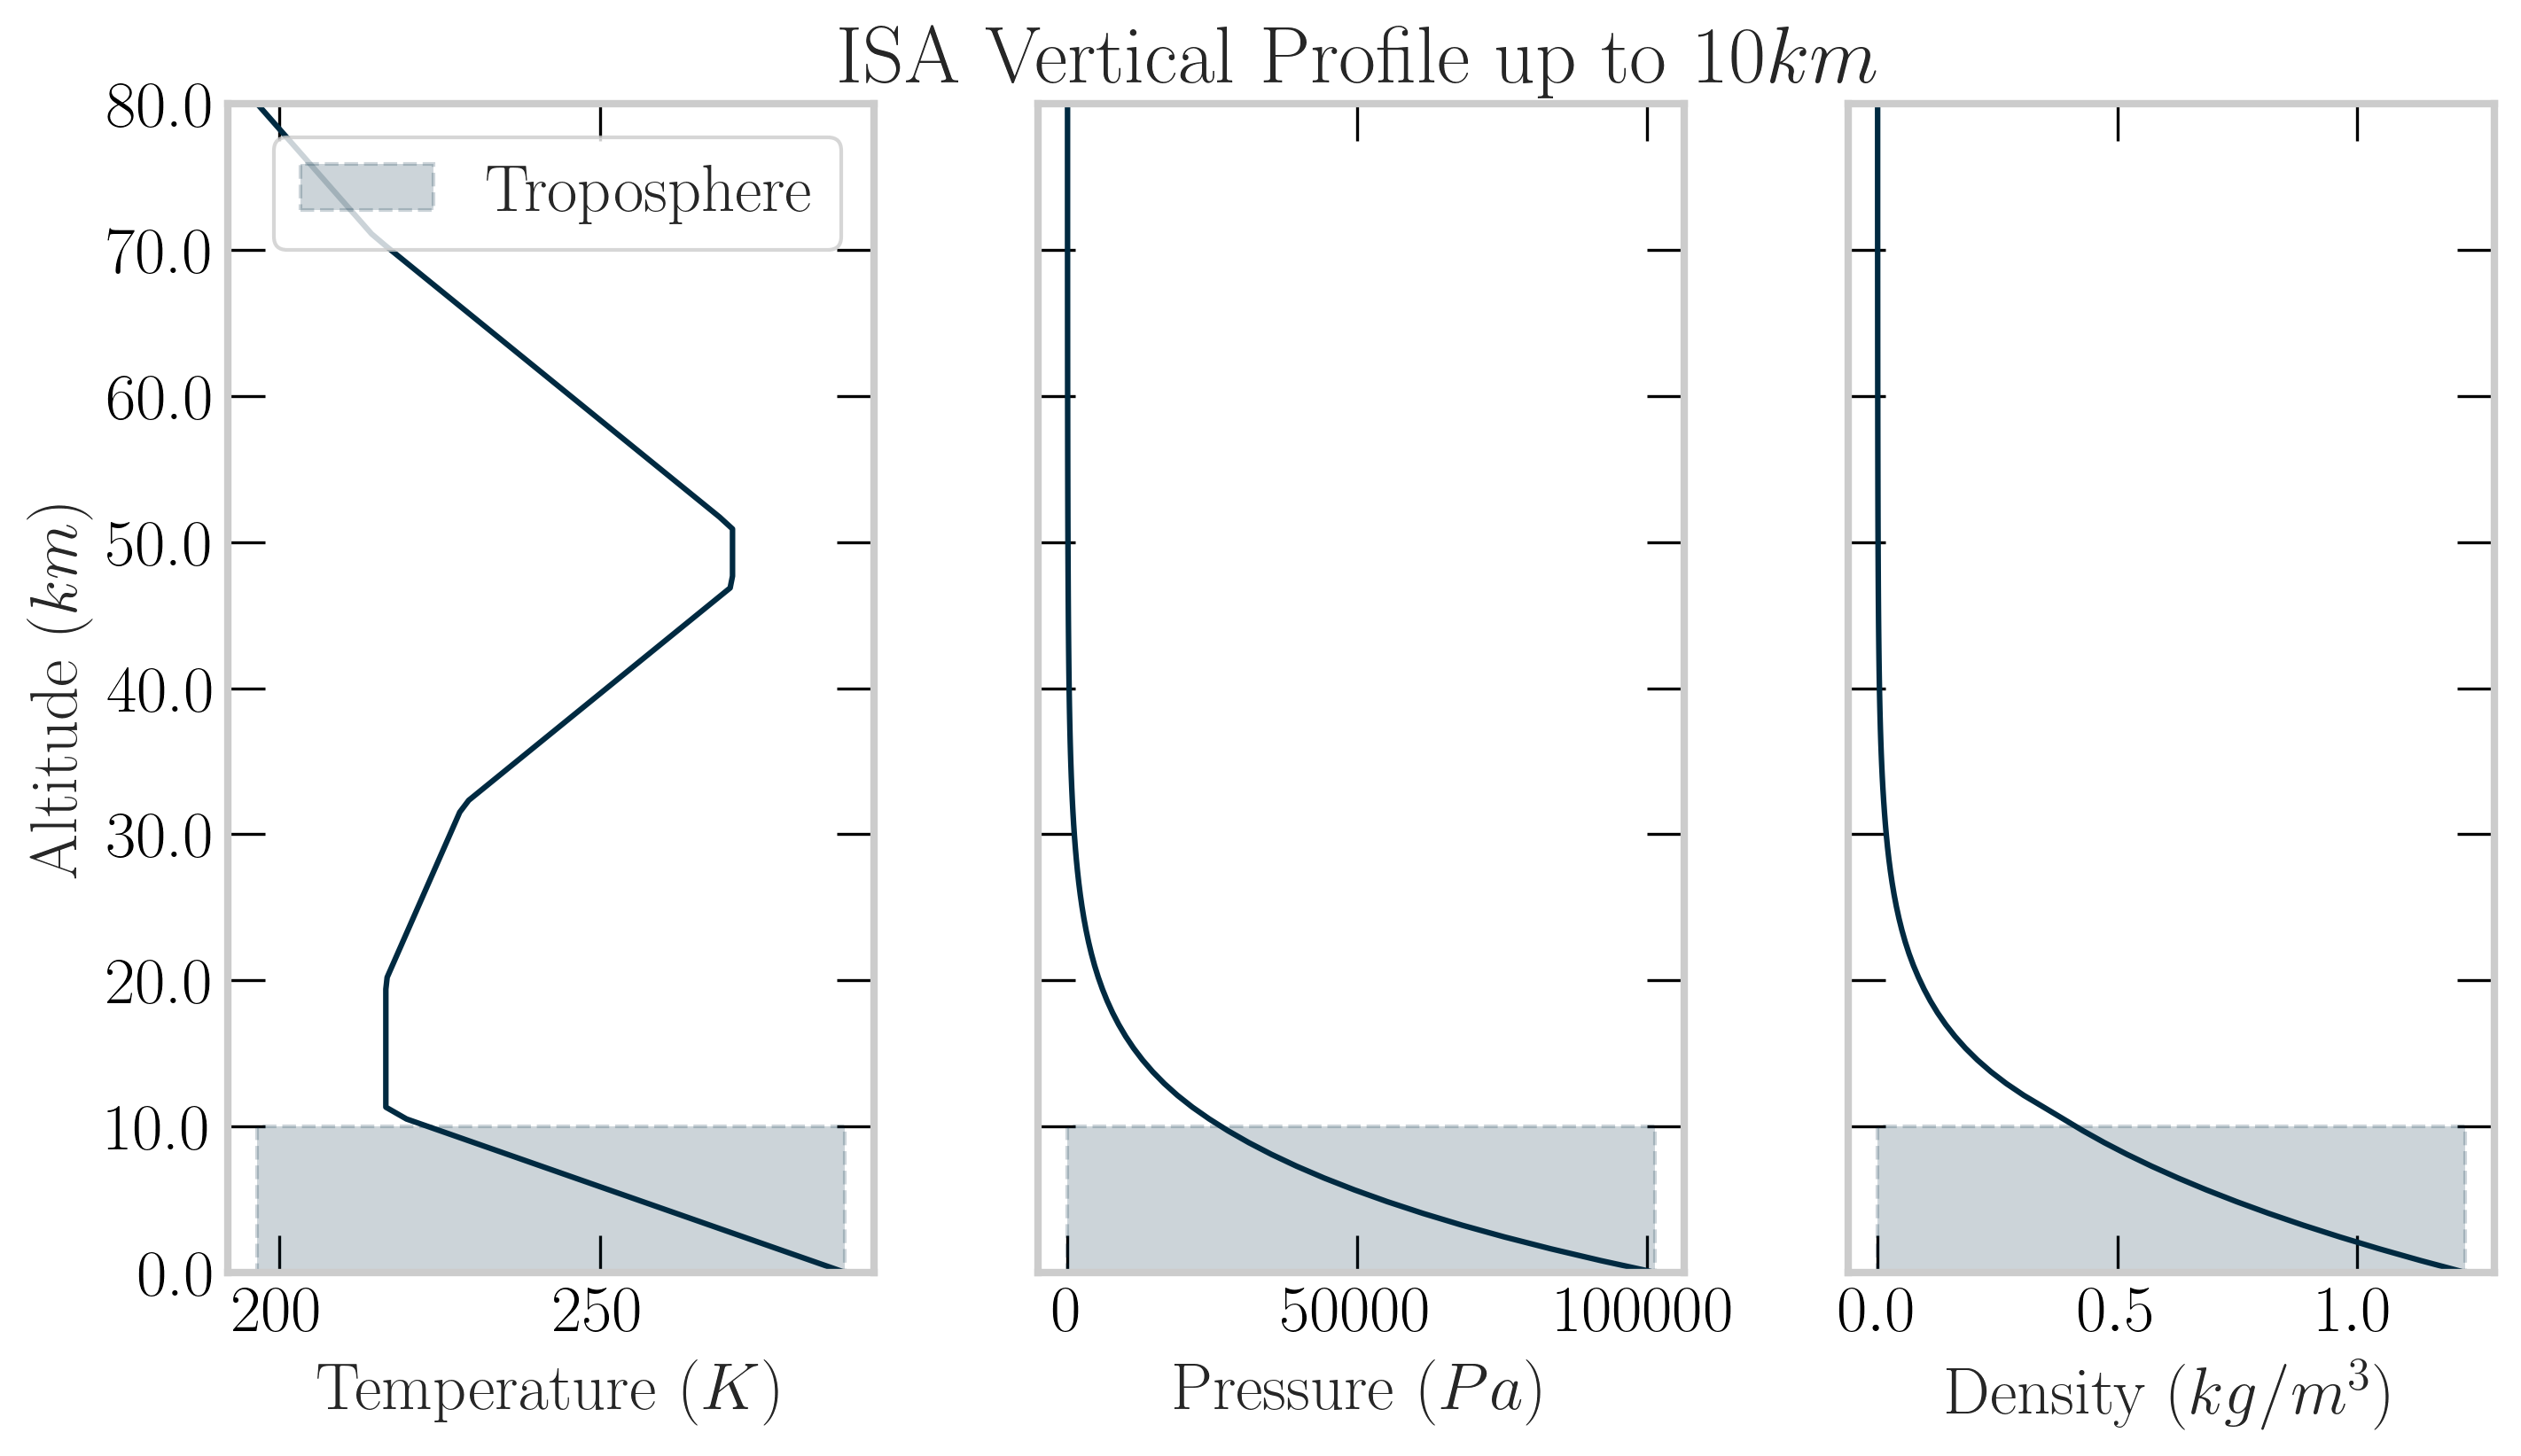

In [11]:
atlittudes = np.linspace(0, 80000, 100)
temp = simpletrans.isa.get_temperature(atlittudes)
pressure = simpletrans.isa.get_pressure(atlittudes)
density = simpletrans.isa.get_density(atlittudes)
fig, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
labels = ["Temperature $(K)$", "Pressure $(Pa)$", "Density $(kg/m^3)$"]
for i, profile in enumerate([temp, pressure, density]):
    ax[i].plot(profile, atlittudes, color=colours.durham.ink)
    ax[i].fill_between(
        [np.min(profile), np.max(profile)],
        [0, 0],
        [10**4, 10**4],
        linestyle="--",
        color=colours.durham.ink,
        label="Troposphere",
        alpha=0.2,
    )
    ax[i].set_yticks(ax[i].get_yticks(), ax[i].get_yticks() / 1000)
    ax[i].set_ylim(0, 80000)
    ax[i].set_xlabel(labels[i])
ax[0].set_ylabel("Altitude $(km)$")
ax[1].set_title("ISA Vertical Profile up to $10km$")
ax[0].legend();

## The Variation of the Absorbtion Cross-section of $\textrm{CO}_2$

The HITRAN Database provides the line-by-line intensities for more than 55 molecules. Using the IPCC reports data on the most potent greenhouse gases, the most impactful three are, $\textrm{CO}_2$, $\textrm{N}_2 \textrm{O}$, and $\textrm{CH}_4$. Additionally, water plays a significant role in the greenhouse effect. However, the variance in its concentration due to anthropogenic factors does not significantly drive global temperature rise. However, it does provide a large amount of radiation scattering and should be included{cite}`IPCCAR6` in our radiation model.

Befor devleloping the radiative transfer model, isolating the broadening behaviour is worthwhile. The changes in $\textrm{CO}_2$'s absorption profile can be used as a litmus test for simplifying assumptions and observing the effects of broadening and gas rarefaction.

Additionally, to temperature and pressure dependence on the broadening, there is a further temperature dependence on the line intensity due to the accessibility of a given transition. At low temperatures, high-energy transitions, those of low wavelength, are heavily suppressed as the molecules lack the energy to access either the excitation or vibrational mode. A Bose-Einstein distribution quantifies the availability of a transition. When the intensity of a transition is known for one temperature, the ratio of the probabilities gives the intensity
```{math}
:label:
S_{a \rightarrow b}(T) = S_{a \rightarrow b, T_ref}\frac{\exp(-h\nu_{a \rightarrow b} /cK_bT)}{exp(-h\nu_{a \rightarrow b} /cK_b T_{ref})} \frac{T_{ref}}{(T)}
```
Where $S_{a \rightarrow b}(T)$ is the line intensity as a function of temperature for some transition $a \rightarrow b$, $\nu_{a \rightarrow b}$ is the wavenumber for the transition, and $Q(T)$ is the partition sum over all states. The values for $S_{a \rightarrow b}(T_{ref})$ are recorded on the HITRAN database.

In the figure below $\textrm{CO}_2$'s line intensity variation is plotted at $1 km$ intervals up to $10km$ using the ISA model, around the most significant absorption lines, around $650 cm^{-1}$. The altitude variation is indicated by the colour of the line, identified by the colour-bar. This region follows the PQR shape that is common in rotational transitions.

In the figure broadening effects can be seen with the high altitude peaks having a narrower line width, than those of low altitude. The overall area of the peaks is largely similar. When calculating radiative transfer, the absorption coefficient determines where the absorption takes place, however the intensity of the absorption is heavily dictated by the density of the gas along the path that the light travels. Optical depth characterizes the amount of light scattered by a medium and is a combination of the abundance of the gas and its absorption coefficient.

In [12]:
"""
This code block demonstrates a simple query to the local database built by
the SimpleTrans package that was developed with the book. The path is to
The Database built by SimpleTrans.
"""
path = "../Database/optical_depth.db"
conn = sqlite3.connect(path)
sql_query = "SELECT * FROM optical_depths WHERE mol_id = 2"
co2_optical_depth = pd.read_sql_query(sql_query, conn)
sql_query = "SELECT * FROM gases"
gases = pd.read_sql_query(sql_query, conn)
alts = co2_optical_depth["altitude"].unique();

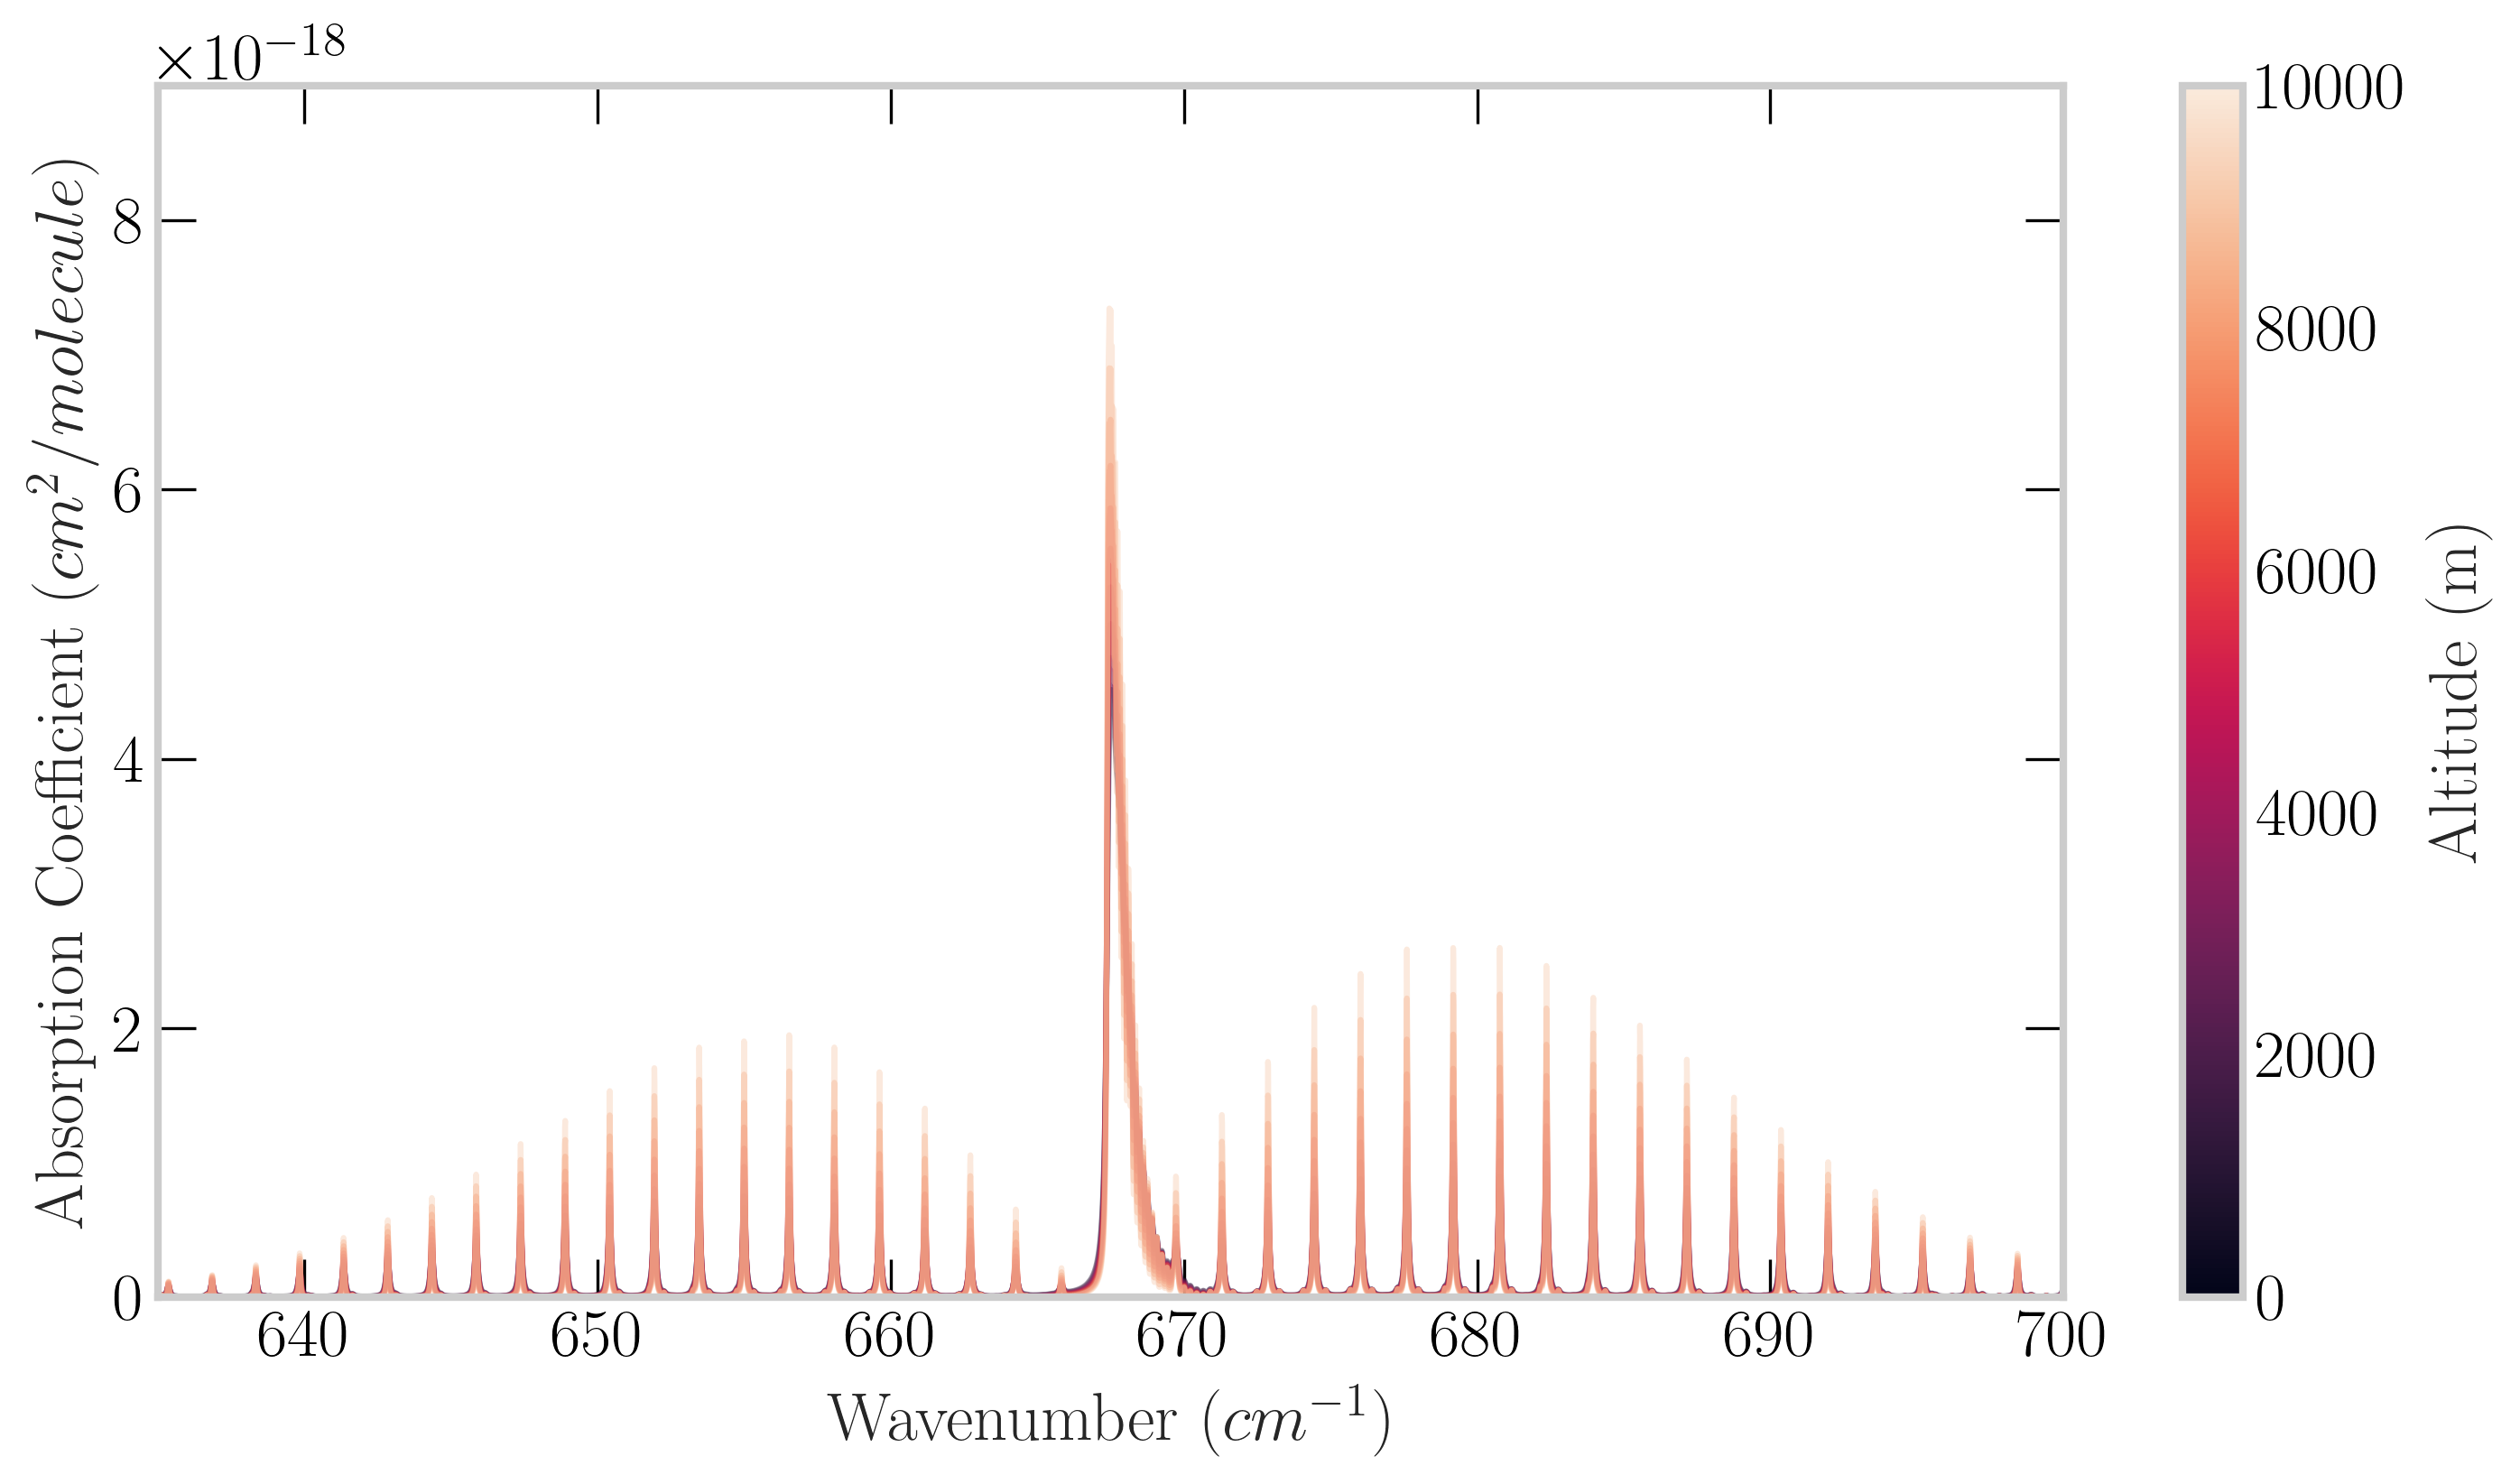

In [13]:
# Initialise Outputs
cmap = sns.color_palette("rocket", 10)
sm = plt.cm.ScalarMappable(
    cmap="rocket", norm=plt.Normalize(vmin=0, vmax=10000)
)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
color_cycle = ax.set_prop_cycle(color=cmap)
for alt in alts:
    if alt <= 9500:
        mask = co2_optical_depth["altitude"] == alt
        abs_coef = co2_optical_depth[mask]["abs_coef"]
        nu = co2_optical_depth[mask]["wave_no"]
        plot = ax.plot(nu, abs_coef, alpha=0.4)

cb = fig.colorbar(sm)
cb.set_label("Altitude (m)")
ax.set_xlim(635, 700)
ax.set_ylim(0, 9 * 10**-18)
ax.set_xlabel("Wavenumber $(cm^{-1})$")
ax.set_ylabel("Absorption Coefficient $(cm^2/molecule)$");

## Optical Depth of $\textrm{CO}_2$

When light is transmitted through the atmosphere the [optical depth](./radiative_transfer.ipynb) is the quantity of interest. This quantity is put into context  in the next section.
The absorption coefficient,$k$, is related to the optical depth$(OD)$ at a wavenumber,$\nu$, by
```{math}
:label:
OD(\nu, \Delta l, T, p) = \int_{l}^{l+\Delta l} n(h) dh \cdot k(\nu, T, p).
```
Where n(h) is the number density per unit volume. Then we plot the optical depth, $I/I_0$, of each atmosphere block up to $30km$.

## Increasing Altitude's effect on Absorption

Because of the density decrease associated with an increase in altitude, the amount of radiation that is absorbed by molecules of $\textrm{CO}_2$ reduces as altitude increases. This effect is in conjunction with the broadening caused by temperature and pressure changes in the atmosphere.


In [14]:
## Comparison of flux ratio difference, with

In [15]:
"""
We create two dictionaries below, that store the ratio of total transmitted
flux, {\int tranmission dwavnumber} / {\int dwavenumber}.  In the
flux_ratios dictionary the absorption coefficient varies with altitude,
flux_ratios_fixed_abs  this takes the absorption coefficient of CO2 at
500 m, and does not vary it while calculating the optical depth.
Additionally, the transmission function is sored in the flux ratio list.
"""

od = []
flux_ratios = []
transmission_fraction = {}
transmission_fraction_fixed_abs = {}
ac_500_mask = co2_optical_depth["altitude"] == 500
ac_500 = co2_optical_depth["abs_coef"][ac_500_mask]

for alt in alts:
    if alt <= 9500:
        mask = co2_optical_depth["altitude"] == alt
        alt_od = co2_optical_depth["optical_depth"][mask]
        od.append(alt_od)
        flux_ratios.append(np.exp(-alt_od))
        fixed_abs_coef_od = optical_depth(
            alt - 500, alt + 500,  400, ac_500
        )
        x = co2_optical_depth["wave_no"][mask]
        flux_ratios_fixed_ac = np.exp(-fixed_abs_coef_od)
        transmission_fraction_fixed_abs[f"{alt}"] = simpson(
            flux_ratios_fixed_ac, x
        ) / simpson(np.ones_like(x), x)
        transmission_fraction[f"{alt}"] = simpson(
            np.exp(-alt_od), co2_optical_depth["wave_no"][mask]
        ) / simpson(np.ones_like(x), x)

In [16]:
result_frame = pd.DataFrame.from_dict(transmission_fraction, "index", columns=["Normal"])
result_frame["Fixed Absorption Coefficient"] = pd.DataFrame.from_dict(transmission_fraction_fixed_abs, "index")
result_frame

,Normal,Fixed Absorption Coefficient
500.0,0.892173,0.892635
1500.0,0.896595,0.894316
2500.0,0.901125,0.896050
3500.0,0.905758,0.897841
4500.0,0.910490,0.899694
5500.0,0.915317,0.901614
6500.0,0.920230,0.903605
7500.0,0.925168,0.905673
8500.0,0.930113,0.907822
9500.0,0.935077,0.910055


The above table shows that there is a total transmission differential of the order of one percent when not including broadening in the CO2 spectrum. This is significant enough that the radiation transfer model, must be able to include this variation.
The figure below plots the ratio of spectral radiance transmitted over the outgoing longwave wavenumber spectrum. The colour bar shows the colour gradient associated with increasing altitude. The dark outlines around the pale areas indicate that temperature and pressure broadening with increased altitude corresponds to a narrowing. This effect can also be seen above plot of the absorption coefficient.

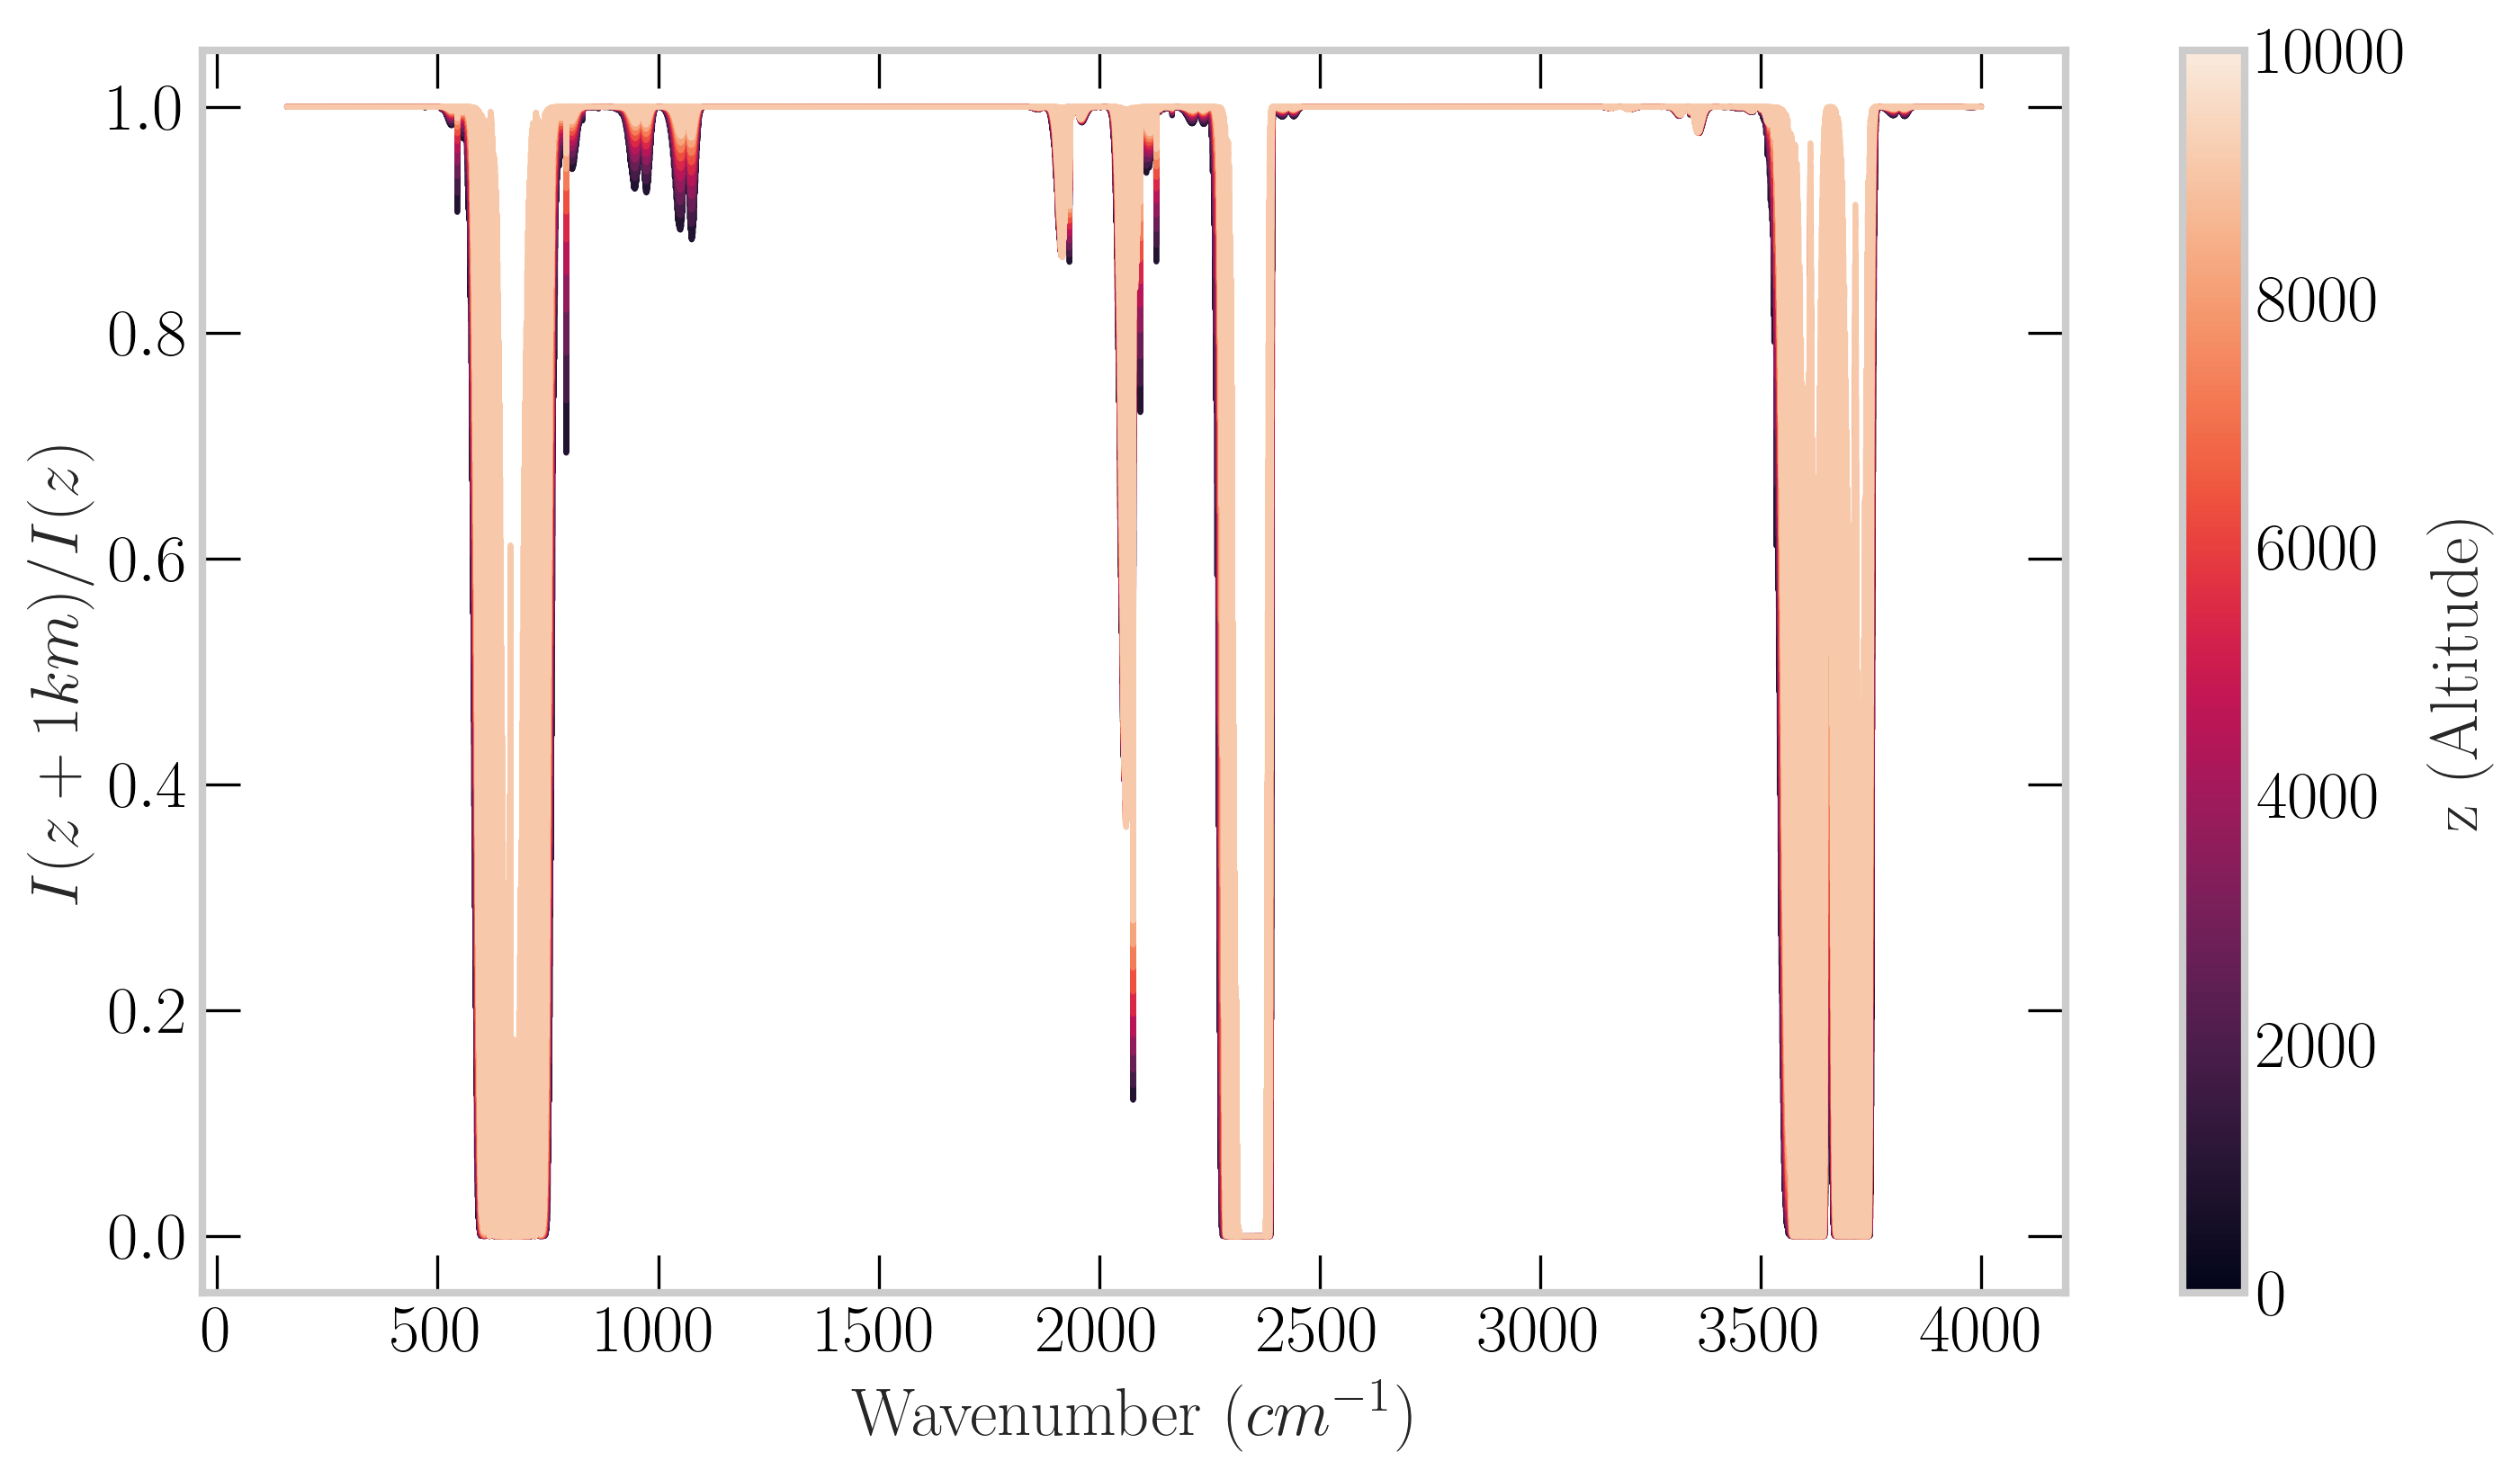

In [17]:

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
color_cycle = ax.set_prop_cycle(color=cmap)
for flux_ratio in flux_ratios:
    plt.plot(nu, flux_ratio, alpha=1)
cb = fig.colorbar(sm)
ax.set_xlabel("Wavenumber $(cm^{-1})$")
ax.set_ylabel("$I(z+1km)/I(z)$")
cb.set_label("z (Altitude)");

## Logarithmic Plot of Optical Depth, $OD$

The previous figure displays clear windows of opacity which decrease in size with increasing altitude. Plotting a semilog plot of the optical depth $\tau$ shows that the values are not as binary as they can appear in the transmission plot above.

 If one was deploying a model of radiative transfer with stricter performance requirements, dropping values from the arrays which don't contribute substantially to the transmission profile, or have an absorption coefficient below some threshold is common practice, the semilog plot highlights the abundance of detail in regions where the transmission function is completely transparent. In addition, if performance is even more of a concern, windowed averaging of regions of interest can also aid in reducing the number of computations, effectively reducing the resolution of the data.

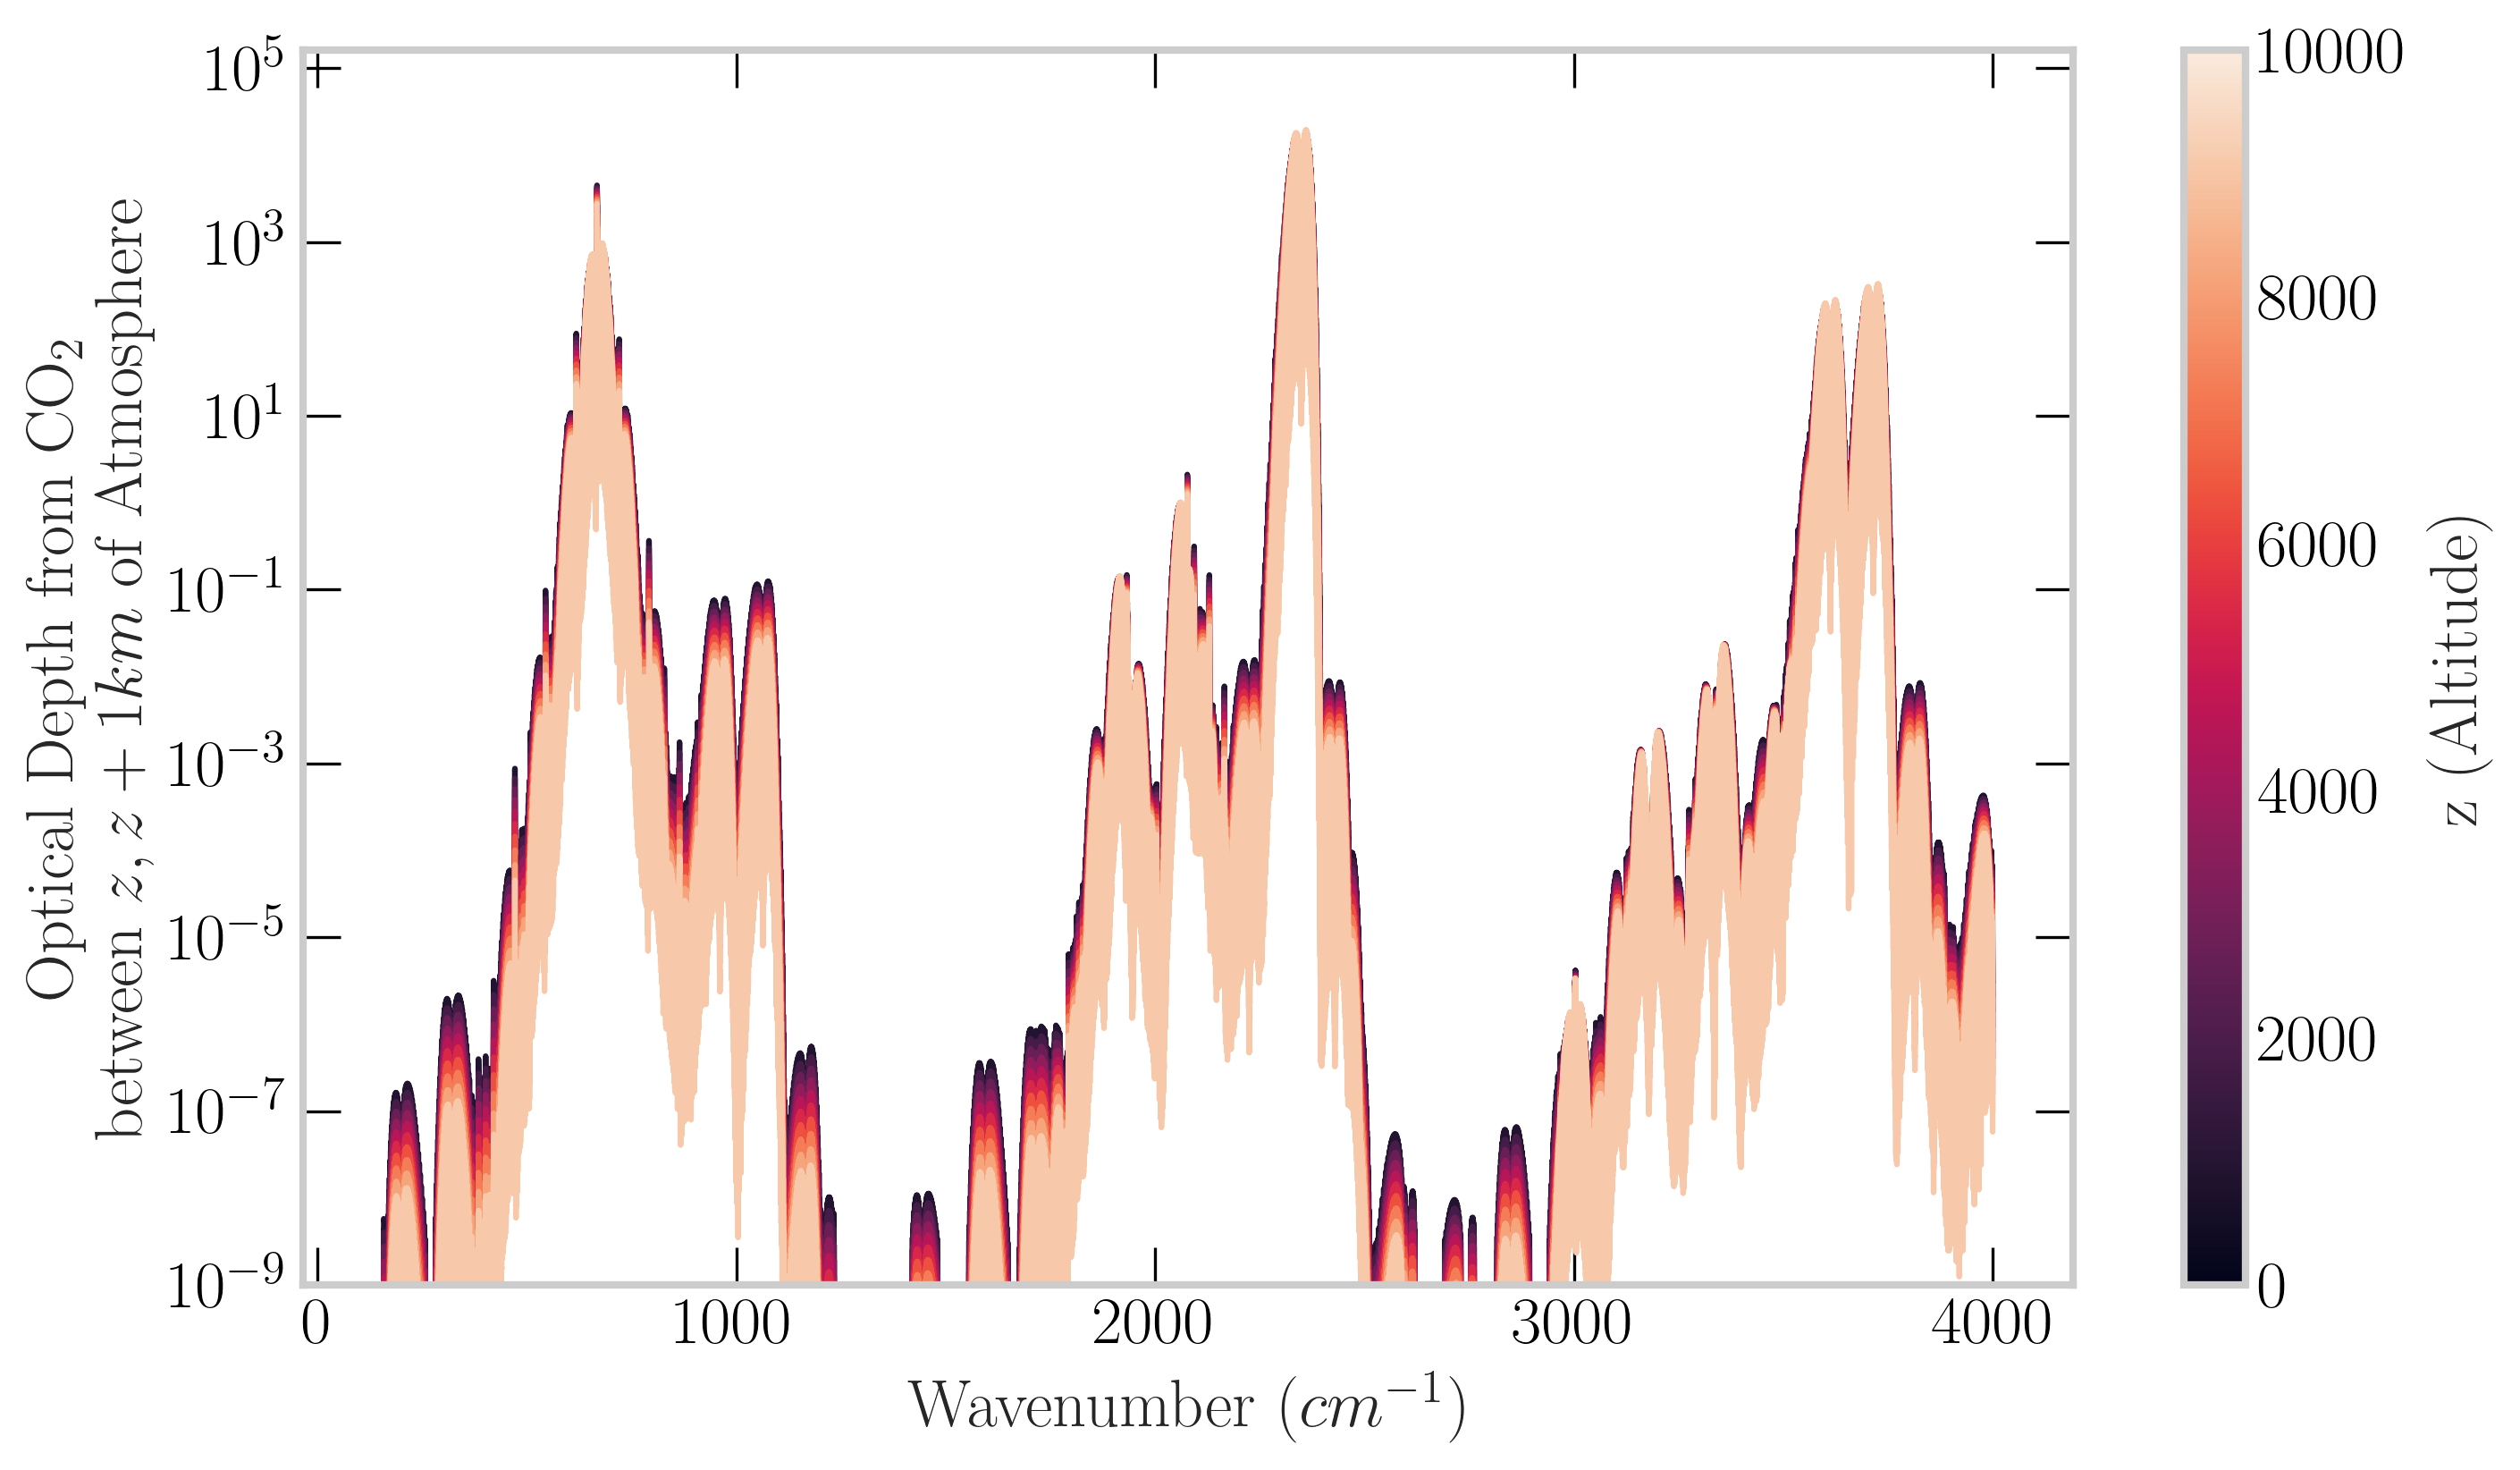

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
color_cycle = ax.set_prop_cycle(color=cmap)

for o_d in od:
    ax.semilogy(nu, o_d)
cb = fig.colorbar(sm)
ax.set_xlabel('Wavenumber $(cm^{-1})$')
ax.set_ylabel(
    'Optical Depth from CO$_2$ \n  between $z, z+1km$ of Atmosphere')
ax.set_ylim(10 ** -9)
cb.set_label('z (Altitude)');

## Moving Forward

## Todo
area difference in the transmission

Clearly, the large change in peak height with varying altitude means that we must account for the variance with transmission of the optical depth of the gases in our radiation transfer model. A common technique used in radiation codes is to smooth the absorption lines and define windows of no absorption to reduce the computational cost.